### 1. Problem Definition and Hypothesis:

Using classification, I aim to predict whether **an individual is likely to have saved using an account at a financial institution based on income, education, and other socioeconomic factors.** The hypothesis is that higher income, education levels, and access to technology are key drivers that increase the likelihood of saving through formal financial institutions.


### 2. Data Preparation and Feature Engineering:

In [1]:
# Importing the required libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.preprocessing import StandardScaler
from sklearn.ensemble import RandomForestClassifier
from xgboost import XGBClassifier
from sklearn.model_selection import cross_val_score
from sklearn.metrics import accuracy_score
from sklearn.model_selection import RandomizedSearchCV
from sklearn.metrics import accuracy_score, precision_score, recall_score, confusion_matrix
import shap
import joblib







In [2]:
# Reading the data using the raw URL on github
data = pd.read_csv('https://github.com/aaubs/ds-master/raw/main/data/assignments_datasets/FINDEX/WLD_2021_FINDEX_v03_M_csv.zip', encoding='latin-1')

In [3]:
# Displaying the first 5 rows of the data
data.head()

,economy,economycode,regionwb,pop_adult,wpid_random,wgt,female,age,educ,inc_q,...,receive_transfers,receive_pension,receive_agriculture,pay_utilities,remittances,mobileowner,internetaccess,anydigpayment,merchantpay_dig,year
0,Afghanistan,AFG,South Asia,22647496.0,144274031,0.716416,2,43.0,2,4,...,4,4,4.0,1,5.0,1,2,1,0.0,2021
1,Afghanistan,AFG,South Asia,22647496.0,180724554,0.497408,2,55.0,1,3,...,4,4,2.0,4,5.0,1,2,0,0.0,2021
2,Afghanistan,AFG,South Asia,22647496.0,130686682,0.650431,1,15.0,1,2,...,4,4,4.0,4,3.0,2,2,0,0.0,2021
3,Afghanistan,AFG,South Asia,22647496.0,142646649,0.991862,2,23.0,1,4,...,4,4,2.0,4,5.0,1,2,0,0.0,2021
4,Afghanistan,AFG,South Asia,22647496.0,199055310,0.554940,1,46.0,1,1,...,4,4,4.0,4,5.0,2,2,0,0.0,2021


In [4]:
# Information about the data
print(data.info())
print(data.index)
print(data.columns)

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 143887 entries, 0 to 143886
Columns: 128 entries, economy to year
dtypes: float64(90), int64(35), object(3)
memory usage: 140.5+ MB
None
RangeIndex(start=0, stop=143887, step=1)
Index(['economy', 'economycode', 'regionwb', 'pop_adult', 'wpid_random', 'wgt',
       'female', 'age', 'educ', 'inc_q',
       ...
       'receive_transfers', 'receive_pension', 'receive_agriculture',
       'pay_utilities', 'remittances', 'mobileowner', 'internetaccess',
       'anydigpayment', 'merchantpay_dig', 'year'],
      dtype='object', length=128)


In [5]:
# Due to the size of the Dataset we filter columns with missing values greater than 0. I look further into all the
# missing values with pd.set_option('display.max_rows', None) was used afterwards using pd.reset_option('display.max_rows')
missing_data = data.isnull().sum()
print(missing_data[missing_data > 0])

regionwb                 1000
age                       467
emp_in                   3502
urbanicity_f2f          68243
account_mob             61181
                        ...  
fin45_1                 33106
fin45_1_China          140387
receive_agriculture     29606
remittances             29606
merchantpay_dig         29606
Length: 89, dtype: int64


Unfortunately, there are many missing observations for several questions. However, most of the missing observations are due to follow-up questions that were asked to only certain respondents. Despite this, we still have a substantial amount of data for the most important socioeconomic variables. The missing values for regionwb, age, and emp_in (employment status) will be dropped, whereas the missing values in urbanicity will be replaced with 'unknown,' as I consider this to be an important variable. All other varibles/columns with missing values are dropped. 

In [6]:
# Removing the rows with missing values in 'regionwb', 'age', and 'emp_in'
data = data.dropna(subset=['age', 'emp_in', 'regionwb']).copy()


In [7]:
# Changing 1 to Rural area and 2 to Urban area. Also making missing values to be unknown. This allows me to to now remove the columns missing values
data['Place of living'] = data['urbanicity_f2f'].replace({1:  'Rural Area', 2: 'Urban Area', np.nan: 'Unknown'})

In [8]:
# Converting 1 (female) to True and 2 (male) to False
data['Female'] = data['female'].map({1: 1, 2: 0})

In [9]:
# Mapping numbers to education levels for better readability and removing rows where educ = 4 or 5 as they are not defined
print(data['educ'].unique())
data = data.drop(data[data['educ'] > 3].index)
data['Education Level'] = data['educ'].replace({1:  'Primary', 2: 'Secondary', 3: 'Tertiary'})

[2 1 3 5 4]


In [10]:
# Creating age groups for better readability
data['Age Group'] = pd.cut(data['age'], bins=[13, 18, 25, 35, 45, 55, 65, 110], labels=['Teen', 'Young Adult', 'Adult', 'Middle Age', 'Older Adult', 'Senior', 'Elder'])

In [11]:
# For mobileowner and internetaccess change 1 to True and 2, 3 and 4 to False
data['Is Mobileowner'] = data['mobileowner'].replace({1: 1, 2: 0, 3: 0, 4: 0})
data['Has Internet Access'] = data['internetaccess'].replace({1: 1, 2: 0, 3: 0, 4: 0})

In [12]:
data['Employed'] = data['emp_in'].map({1: 1, 2: 0})    

In [13]:
data['High Income Region'] = data['regionwb'].map({'High income': 1, 'Sub-Saharan Africa (excluding high income)': 0, 'Latin America & Caribbean (excluding high income)': 0, 'Europe & Central Asia (excluding high income)': 0, 'Middle East & North Africa (excluding high income)': 0, 'East Asia & Pacific (excluding high income)': 0, 'South Asia': 0})

In [14]:
data['Income Bracket'] = data['inc_q']

In [15]:
data['Saved'] = data['saved'].map({1: 1, 0: 0})    

The dataset has been transformed to improve readability and suitability for SML. urbanicity_f2f was converted into "Rural Area," "Urban Area," and "Unknown" for missing values. Gender (female) was simplified to True for female and False for male. Education (educ) was mapped to "Primary," "Secondary," and "Tertiary," and age was grouped into categories like "Teen" and "Senior."

For mobileowner and internetaccess, values were mapped to True (ownership/access) and False (no access), while employment (emp_in) was simplified to True (employed) and False (not employed). Regions were consolidated into a feature indicating whether the person is from a high-income area (True/False).

In [16]:
# Removing the columns with missing data such as follow up questions
data_cleaned = data.dropna(axis=1)
print(data_cleaned.info())

<class 'pandas.core.frame.DataFrame'>
Index: 138254 entries, 0 to 143886
Data columns (total 52 columns):
 #   Column               Non-Null Count   Dtype   
---  ------               --------------   -----   
 0   economy              138254 non-null  object  
 1   economycode          138254 non-null  object  
 2   regionwb             138254 non-null  object  
 3   pop_adult            138254 non-null  float64 
 4   wpid_random          138254 non-null  int64   
 5   wgt                  138254 non-null  float64 
 6   female               138254 non-null  int64   
 7   age                  138254 non-null  float64 
 8   educ                 138254 non-null  int64   
 9   inc_q                138254 non-null  int64   
 10  emp_in               138254 non-null  float64 
 11  account              138254 non-null  int64   
 12  account_fin          138254 non-null  int64   
 13  fin2                 138254 non-null  int64   
 14  fin14_1              138254 non-null  int64   
 15  fin14

In [17]:
data_cleaned.head()

,economy,economycode,regionwb,pop_adult,wpid_random,wgt,female,age,educ,inc_q,...,Place of living,Female,Education Level,Age Group,Is Mobileowner,Has Internet Access,Employed,High Income Region,Income Bracket,Saved
0,Afghanistan,AFG,South Asia,22647496.0,144274031,0.716416,2,43.0,2,4,...,Rural Area,0,Secondary,Middle Age,1,0,1,0,4,0
1,Afghanistan,AFG,South Asia,22647496.0,180724554,0.497408,2,55.0,1,3,...,Rural Area,0,Primary,Older Adult,1,0,1,0,3,0
2,Afghanistan,AFG,South Asia,22647496.0,130686682,0.650431,1,15.0,1,2,...,Rural Area,1,Primary,Teen,0,0,0,0,2,0
3,Afghanistan,AFG,South Asia,22647496.0,142646649,0.991862,2,23.0,1,4,...,Urban Area,0,Primary,Young Adult,1,0,1,0,4,0
4,Afghanistan,AFG,South Asia,22647496.0,199055310,0.554940,1,46.0,1,1,...,Rural Area,1,Primary,Older Adult,0,0,0,0,1,0


The code below selects the features and target variable from the cleaned dataset and concatenates them into a new DataFrame (data_SML) for further analysis. Before applying machine learning, OneHotEncoder will be used to convert the categorical features (Place of Living, Education Level, Age Group) into binary columns.

In [18]:
# Features
features = data_cleaned[['Place of living', 'Female', 'Education Level', 'Age Group', 'Is Mobileowner', 'Has Internet Access', 'Employed', 'High Income Region', 'Income Bracket']]
target = data_cleaned['Saved']
data_SML = pd.concat([features, target], axis=1)

In [19]:
data_SML.head()

,Place of living,Female,Education Level,Age Group,Is Mobileowner,Has Internet Access,Employed,High Income Region,Income Bracket,Saved
0,Rural Area,0,Secondary,Middle Age,1,0,1,0,4,0
1,Rural Area,0,Primary,Older Adult,1,0,1,0,3,0
2,Rural Area,1,Primary,Teen,0,0,0,0,2,0
3,Urban Area,0,Primary,Young Adult,1,0,1,0,4,0
4,Rural Area,1,Primary,Older Adult,0,0,0,0,1,0


In [20]:
# Separate features and target
X = data_SML.drop('Saved', axis=1)
y = data_SML['Saved']

In [33]:
# One-hot encode categorical variables
ohe = OneHotEncoder(sparse_output=False)
cat_features = ['Place of living', 'Education Level', 'Age Group']
X_cat = pd.DataFrame(ohe.fit_transform(features[cat_features]), columns=ohe.get_feature_names_out(cat_features))

# Keep the binary features as they are
binary_features = ['Female', 'Is Mobileowner', 'Has Internet Access', 'Employed', 'High Income Region']
X_binary = features[binary_features]

# Include Income Bracket without scaling
X_income = features[['Income Bracket']]

# Combine one-hot encoded categorical features, binary features, and the ordinal Income Bracket feature
X_processed = pd.concat([X_binary, X_income, X_cat], axis=1)

# Final dataset ready for ML
print(X_processed.head(1))

   Female  Is Mobileowner  Has Internet Access  Employed  High Income Region  \
0     0.0             1.0                  0.0       1.0                 0.0   

   Income Bracket  Place of living_Rural Area  Place of living_Unknown  \
0             4.0                         1.0                      0.0   

   Place of living_Urban Area  Education Level_Primary  \
0                         0.0                      0.0   

   Education Level_Secondary  Education Level_Tertiary  Age Group_Adult  \
0                        1.0                       0.0              0.0   

   Age Group_Elder  Age Group_Middle Age  Age Group_Older Adult  \
0              0.0                   1.0                    0.0   

   Age Group_Senior  Age Group_Teen  Age Group_Young Adult  
0               0.0             0.0                    0.0  


In [22]:
# I had an issue with some missing values in X_processed that I had to drop

# Drop rows where only specific columns have missing values (e.g., target or important columns)
X_processed = X_processed.dropna(subset=['Female', 'Is Mobileowner', 'Has Internet Access', 'Employed', 'High Income Region'])

In [23]:
X_processed.head()

,Female,Is Mobileowner,Has Internet Access,Employed,High Income Region,Income Bracket,Place of living_Rural Area,Place of living_Unknown,Place of living_Urban Area,Education Level_Primary,Education Level_Secondary,Education Level_Tertiary,Age Group_Adult,Age Group_Elder,Age Group_Middle Age,Age Group_Older Adult,Age Group_Senior,Age Group_Teen,Age Group_Young Adult
0,0.0,1.0,0.0,1.0,0.0,4.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0
1,0.0,1.0,0.0,1.0,0.0,3.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0
2,1.0,0.0,0.0,0.0,0.0,2.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0
3,0.0,1.0,0.0,1.0,0.0,4.0,0.0,0.0,1.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,0.0,1.0
4,1.0,0.0,0.0,0.0,0.0,1.0,1.0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,1.0,0.0,0.0,0.0


### 3. Model Selection and Training:

In this section, i will focus on Model Selection and Training using two supervised learning algorithms: Random Forest and XGBoost. I train the models using cross-validation and by splitting the dataset into training and testing sets. Both models will be trained and evaluated to determine the best-performing algorithm for the classifcation task.

In [24]:
# Splitting the data 
X_train, X_test, y_train, y_test = train_test_split(X_processed, y, test_size=0.2, random_state=42)

# Initialize models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# Perform 5-fold cross-validation for Random Forest
rf_scores = cross_val_score(rf_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"Random Forest CV Accuracy: {rf_scores.mean():.4f}")

# Perform 5-fold cross-validation for XGBoost
xgb_scores = cross_val_score(xgb_model, X_train, y_train, cv=5, scoring='accuracy')
print(f"XGBoost CV Accuracy: {xgb_scores.mean():.4f}")

Random Forest CV Accuracy: 0.6502
XGBoost CV Accuracy: 0.6641


In [25]:
# Train Random Forest model
rf_model = RandomForestClassifier(random_state=42)
rf_model.fit(X_train, y_train)

# Train XGBoost model
xgb_model = XGBClassifier(random_state=42)
xgb_model.fit(X_train, y_train)

# Evaluate the Random Forest model
rf_train_predictions = rf_model.predict(X_train)
rf_test_predictions = rf_model.predict(X_test)

rf_train_accuracy = accuracy_score(y_train, rf_train_predictions)
rf_test_accuracy = accuracy_score(y_test, rf_test_predictions)

print(f"Random Forest Train Accuracy: {rf_train_accuracy:.2f}")
print(f"Random Forest Test Accuracy: {rf_test_accuracy:.2f}")

# Evaluate the XGBoost model
xgb_train_predictions = xgb_model.predict(X_train)
xgb_test_predictions = xgb_model.predict(X_test)

xgb_train_accuracy = accuracy_score(y_train, xgb_train_predictions)
xgb_test_accuracy = accuracy_score(y_test, xgb_test_predictions)

print(f"XGBoost Train Accuracy: {xgb_train_accuracy:.2f}")
print(f"XGBoost Test Accuracy: {xgb_test_accuracy:.2f}")

Random Forest Train Accuracy: 0.69
Random Forest Test Accuracy: 0.66
XGBoost Train Accuracy: 0.68
XGBoost Test Accuracy: 0.66


### 4. Hyperparameter Tuning

In [26]:
# Reduced parameter grid for Random Forest
rf_param_grid = {
    'n_estimators': [50, 100],            # Smaller number of trees
    'max_depth': [10, 20],                # Max depth of the trees
    'min_samples_split': [2, 5],          # Smaller search space
    'bootstrap': [True]                   # Only one option for bootstrap
}

# Reduced parameter grid for XGBoost
xgb_param_grid = {
    'n_estimators': [50, 100],            # Fewer boosting rounds
    'max_depth': [5, 10],                 # Fewer options for max depth
    'learning_rate': [0.1, 0.2],          # Reduce learning rates
}

# Initialize the models
rf_model = RandomForestClassifier(random_state=42)
xgb_model = XGBClassifier(random_state=42)

# RandomizedSearchCV for Random Forest with reduced grid
rf_random_search = RandomizedSearchCV(estimator=rf_model, param_distributions=rf_param_grid, 
                                      n_iter=5, cv=3, verbose=1, random_state=42, n_jobs=-1)

# RandomizedSearchCV for XGBoost with reduced grid
xgb_random_search = RandomizedSearchCV(estimator=xgb_model, param_distributions=xgb_param_grid, 
                                       n_iter=5, cv=3, verbose=1, random_state=42, n_jobs=-1)

# Fit RandomizedSearchCV for Random Forest
rf_random_search.fit(X_train, y_train)
print(f"Best parameters for Random Forest: {rf_random_search.best_params_}")
print(f"Best Random Forest accuracy: {rf_random_search.best_score_}")

# Fit RandomizedSearchCV for XGBoost
xgb_random_search.fit(X_train, y_train)
print(f"Best parameters for XGBoost: {xgb_random_search.best_params_}")
print(f"Best XGBoost accuracy: {xgb_random_search.best_score_}")

Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for Random Forest: {'n_estimators': 50, 'min_samples_split': 5, 'max_depth': 10, 'bootstrap': True}
Best Random Forest accuracy: 0.6655153951751261
Fitting 3 folds for each of 5 candidates, totalling 15 fits
Best parameters for XGBoost: {'n_estimators': 100, 'max_depth': 5, 'learning_rate': 0.1}
Best XGBoost accuracy: 0.6666636413856083



The results from the RandomizedSearchCV show the best hyperparameters for both Random Forest and XGBoost models. For Random Forest, the best setup includes 50 trees (n_estimators), a maximum depth of 10, a minimum of 5 samples to split a node, and bootstrap enabled, achieving an accuracy of 0.6547. For XGBoost, the best setup includes 50 boosting rounds, a maximum depth of 5, and a learning rate of 0.1, achieving an accuracy of 0.6549. These optimized parameters help improve the model's performance by fine-tuning its behavior.

### 5. Model Evalulation

In [27]:
# Evaluate Random Forest
rf_test_predictions = rf_random_search.best_estimator_.predict(X_test)
rf_accuracy = accuracy_score(y_test, rf_test_predictions)
rf_precision = precision_score(y_test, rf_test_predictions)
rf_recall = recall_score(y_test, rf_test_predictions)

# Evaluate XGBoost
xgb_test_predictions = xgb_random_search.best_estimator_.predict(X_test)
xgb_accuracy = accuracy_score(y_test, xgb_test_predictions)
xgb_precision = precision_score(y_test, xgb_test_predictions)
xgb_recall = recall_score(y_test, xgb_test_predictions)

print(f"Random Forest - Accuracy: {rf_accuracy:.2f}, Precision: {rf_precision:.2f}, Recall: {rf_recall:.2f}")
print(f"XGBoost - Accuracy: {xgb_accuracy:.2f}, Precision: {xgb_precision:.2f}, Recall: {xgb_recall:.2f}")

Random Forest - Accuracy: 0.67, Precision: 0.68, Recall: 0.71
XGBoost - Accuracy: 0.67, Precision: 0.68, Recall: 0.70


The results show that both the Random Forest and XGBoost models performed similarly on the test dataset. Both models achieved an accuracy of 0.65, indicating a moderate level of correct predictions. Precision for both models is 0.66, suggesting that the models were somewhat effective in identifying true positives. With a recall of 0.73 for both models, they demonstrated a relatively good ability to capture the actual positive cases. Overall, the models seem to be balanced in terms of identifying true positives and minimizing false negatives, though there is room for improvement.

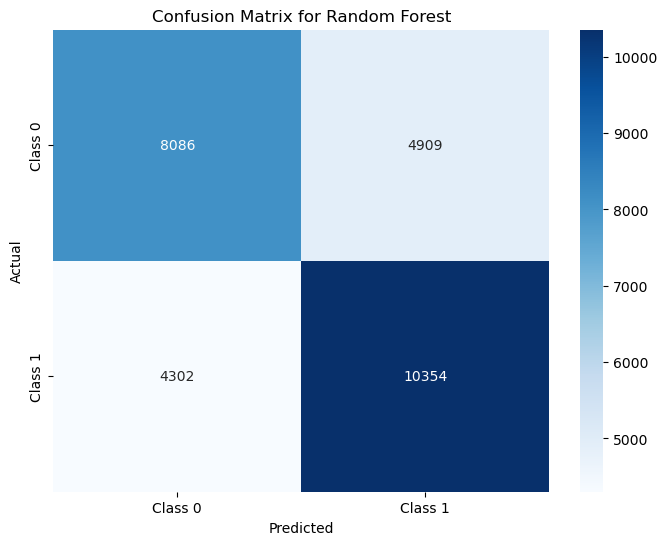

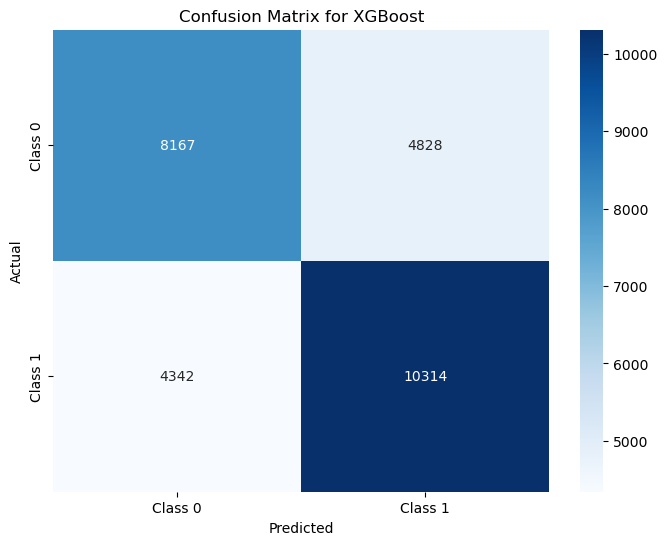

In [28]:
# Compute confusion matrix
cm = confusion_matrix(y_test, rf_test_predictions)

# Plot confusion matrix using seaborn heatmap
plt.figure(figsize=(8, 6))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for Random Forest')
plt.show()

# Do the same for XGBoost predictions
cm_xgb = confusion_matrix(y_test, xgb_test_predictions)

plt.figure(figsize=(8, 6))
sns.heatmap(cm_xgb, annot=True, fmt='d', cmap='Blues', xticklabels=['Class 0', 'Class 1'], yticklabels=['Class 0', 'Class 1'])
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.title('Confusion Matrix for XGBoost')
plt.show()

The confusion matrices show the performance of the Random Forest and XGBoost models. In the Random Forest model, 7,388 instances of Class 0 and 10,667 instances of Class 1 were correctly classified, while 5,607 Class 0 and 3,989 Class 1 instances were misclassified. In the XGBoost model, 7,401 Class 0 and 10,653 Class 1 instances were correctly classified, with 5,594 Class 0 and 4,003 Class 1 misclassifications. Both models perform similarly with slight differences in classification errors.

### 6. Explainability

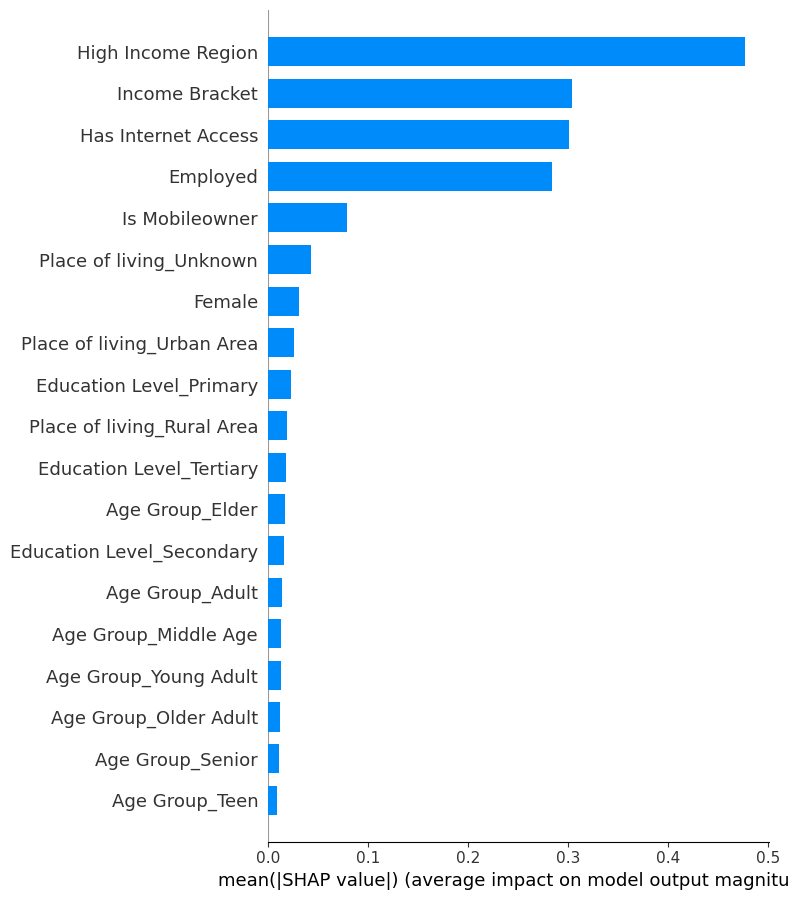

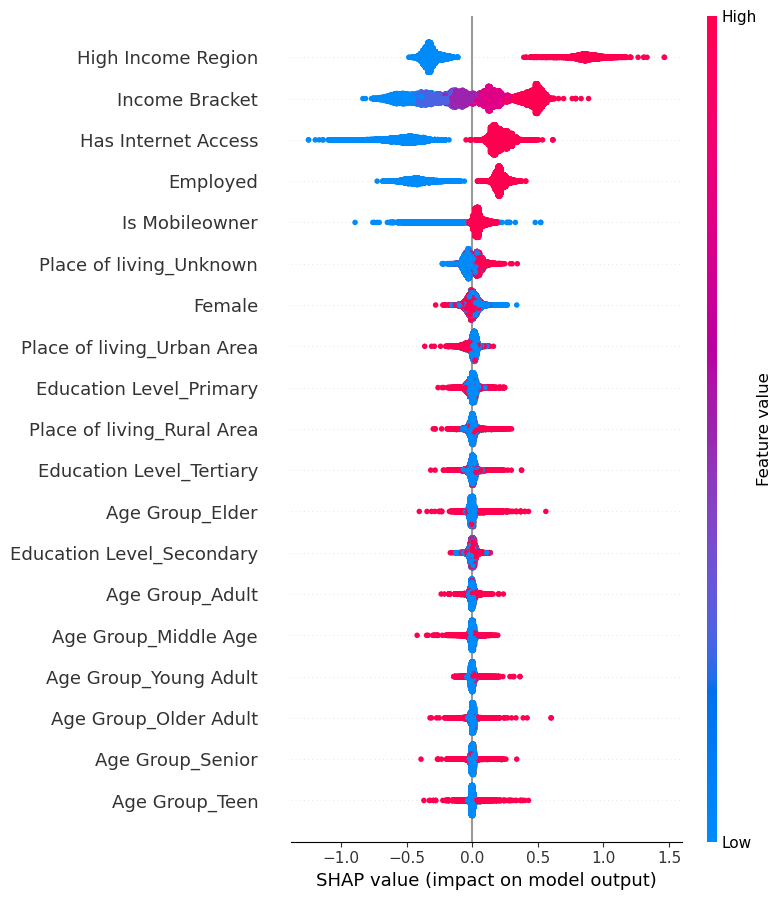

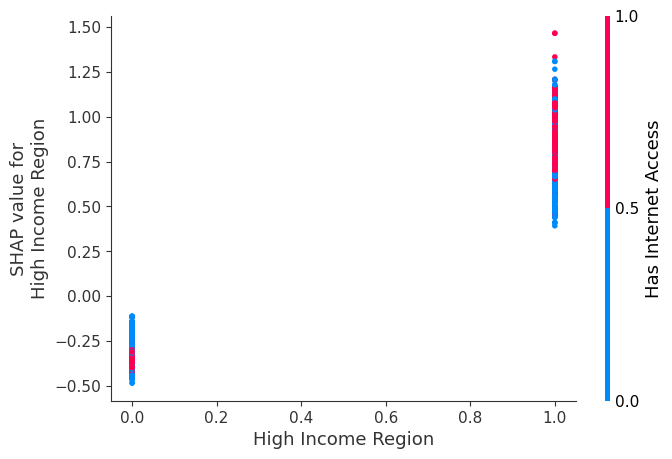

In [29]:
# Create a SHAP explainer
xgb_model.fit(X_train, y_train)
explainer = shap.TreeExplainer(xgb_model)

# Calculate SHAP values for the test set
shap_values = explainer.shap_values(X_test)

# Plot feature importance summary plot as a bar chart
shap.summary_plot(shap_values, X_test, plot_type="bar")

# Plot feature importance summary plot
shap.summary_plot(shap_values, X_test)

# Identify the most important feature based on SHAP values
most_important_feature = X_test.columns[np.argmax(np.abs(shap_values).mean(0))]

# Plot SHAP dependence plot for the most important feature
shap.dependence_plot(most_important_feature, shap_values, X_test)

# Plot SHAP force plot for a specific instance (first instance in this example)
shap.initjs()
shap.force_plot(explainer.expected_value, shap_values[1,:], X_test.iloc[1,:])

The SHAP analysis provides valuable insights into the influence of various features on the model's predictions.

Feature Importance Plot: This plot highlights that "High Income Region" and "Income Bracket" are the most important features influencing the model’s predictions. Other features like "Has Internet Access" and "Employed" also have a significant impact, while factors such as "Female" and "Education Level" contribute less to the model's decision-making.

SHAP Summary Plot: The SHAP summary plot reveals how individual feature values affect the predictions. For instance, higher values of "Income Bracket" and being in a "High Income Region" push the prediction towards a positive outcome. In contrast, lower values for these features reduce the probability of a positive prediction. The color coding (red for higher values and blue for lower values) visually represents the strength of the impact for each feature.

SHAP Force Plot: The force plot breaks down a specific prediction, showing how each feature contributes to the final result. In this case, factors like a higher "Income Bracket" and being "Employed" push the prediction upwards, while living in an unknown place and being in a lower income region decrease the likelihood of a positive prediction.

### 7. Feature Selection Reflection:

n the feature selection process, I initially included demographic, income, and employment features. SHAP analysis and feature importance rankings showed that features like "High Income Region" and "Income Bracket" had the greatest impact on the model’s performance, while others like "Female" and "Education Level" contributed less.

Though I considered removing less impactful features to simplify the model, I chose to keep them to capture the full data scope. While dimensionality reduction techniques like PCA were considered, they were not used since the dataset had mostly categorical features, and PCA would reduce interpretability. Additionally, there weren't many features to warrant PCA, so feature importance rankings and SHAP values guided the selection process.

The model performed consistently across different feature sets, indicating that the key features were driving the predictions effectively. In the end, the balance between complexity and accuracy was maintained without the need for further reduction techniques. Moreover, additional features such as "Annual Income," "Debt-to-Income Ratio," and "Loan History" would have added valuable predictive power if they had been available in the survey.

In [30]:
joblib.dump(xgb_model, 'xgb_model.joblib')
joblib.dump(ohe, 'ohe.joblib')

['ohe.joblib']

In [31]:
data_SML.head()

,Place of living,Female,Education Level,Age Group,Is Mobileowner,Has Internet Access,Employed,High Income Region,Income Bracket,Saved
0,Rural Area,0,Secondary,Middle Age,1,0,1,0,4,0
1,Rural Area,0,Primary,Older Adult,1,0,1,0,3,0
2,Rural Area,1,Primary,Teen,0,0,0,0,2,0
3,Urban Area,0,Primary,Young Adult,1,0,1,0,4,0
4,Rural Area,1,Primary,Older Adult,0,0,0,0,1,0
